In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

from numba import jit, float64, int64

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[2] += v[2]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b and x[2]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b and x[2]<b:
            ch = 1.0
            stop = True
        elif x[2]>= b and x[0]<b and x[1]<b:
            ch = 2.0
            stop = True
        elif (x[0]>= b and x[1]>=b) or (x[1]>= b and x[2]>=b) or (x[0]>= b and x[2]>=b):
            rt = 0
            x = np.array([0.0, 0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../../_data/Kr2011.csv')
data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['rt'] /= 1000

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df['choice_0'] = pd.get_dummies(data_df['choice'])[0]
data_df['choice_1'] = pd.get_dummies(data_df['choice'])[1]
data_df['choice_2'] = pd.get_dummies(data_df['choice'])[2]

mov = (data_df['item_value_0'] + data_df['item_value_1'])/2

data_df['Right Value - Mean Other Value'] = data_df['item_value_2'] - mov
kbins1 = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['Right Value - Mean Other Value'] = 2*(kbins1.fit_transform(data_df[['Right Value - Mean Other Value']])-4)

data_df['gaze diff'] = data_df['gaze_2'] - (data_df['gaze_0'] + data_df['gaze_1'])
kbins2 = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins2.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - O)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.5)

obs_train = np.asarray(tr_df[['rt', 'choice_0', 'choice_1', 'choice_2', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'item_value_2', 
                            'gaze_0', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'choice_0', 'choice_1', 'choice_2', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'item_value_2', 
                           'gaze_0', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(1454, 6) (1468, 6)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    
    sbj_indices = tf.cast(data[:, 4], tf.int32)
    
    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))
    

    
    ll1 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll2 = (obs_train[:, 2]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll3 = (obs_train[:, 3]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    
    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2 + ll3, 1e-14)), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=3, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 10, 10]
input_shape = 6
output_shape = 3
activation = 'sigmoid'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 out_layer (Out_layer)       (None, 3)                 123       
                                                                 
Total params: 523 (2.04 KB)
Trainable params: 523 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 4], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 1s 824ms/step - loss: 14273.5107
Epoch 2/4000
1/1 [==============================] - 0s 2ms/step - loss: 14170.8643
Epoch 3/4000
1/1 [==============================] - 0s 2ms/step - loss: 14098.4521
Epoch 4/4000
1/1 [==============================] - 0s 2ms/step - loss: 14038.9219
Epoch 5/4000
1/1 [==============================] - 0s 4ms/step - loss: 13986.8223
Epoch 6/4000
1/1 [==============================] - 0s 3ms/step - loss: 13939.6387
Epoch 7/4000
1/1 [==============================] - 0s 3ms/step - loss: 13895.9658
Epoch 8/4000
1/1 [==============================] - 0s 2ms/step - loss: 13854.9326
Epoch 9/4000
1/1 [==============================] - 0s 2ms/step - loss: 13815.9639
Epoch 10/4000
1/1 [==============================] - 0s 2ms/step - loss: 13778.6533
Epoch 11/4000
1/1 [==============================] - 0s 2ms/step - loss: 13742.7012
Epoch 12/4000
1/1 [==============================] - 0s 3ms/step - loss: 13707.8848

1/1 [==============================] - 0s 2ms/step - loss: 11609.8896
Epoch 99/4000
1/1 [==============================] - 0s 3ms/step - loss: 11591.0244
Epoch 100/4000
1/1 [==============================] - 0s 2ms/step - loss: 11572.2705
Epoch 101/4000
1/1 [==============================] - 0s 2ms/step - loss: 11553.6338
Epoch 102/4000
1/1 [==============================] - 0s 2ms/step - loss: 11535.1094
Epoch 103/4000
1/1 [==============================] - 0s 2ms/step - loss: 11516.7002
Epoch 104/4000
1/1 [==============================] - 0s 2ms/step - loss: 11498.4043
Epoch 105/4000
1/1 [==============================] - 0s 3ms/step - loss: 11480.2188
Epoch 106/4000
1/1 [==============================] - 0s 2ms/step - loss: 11462.1514
Epoch 107/4000
1/1 [==============================] - 0s 2ms/step - loss: 11444.1924
Epoch 108/4000
1/1 [==============================] - 0s 2ms/step - loss: 11426.3477
Epoch 109/4000
1/1 [==============================] - 0s 2ms/step - loss: 11408.6

1/1 [==============================] - 0s 2ms/step - loss: 10255.5830
Epoch 195/4000
1/1 [==============================] - 0s 2ms/step - loss: 10245.4512
Epoch 196/4000
1/1 [==============================] - 0s 2ms/step - loss: 10235.3857
Epoch 197/4000
1/1 [==============================] - 0s 2ms/step - loss: 10225.3818
Epoch 198/4000
1/1 [==============================] - 0s 2ms/step - loss: 10215.4385
Epoch 199/4000
1/1 [==============================] - 0s 3ms/step - loss: 10205.5576
Epoch 200/4000
1/1 [==============================] - 0s 2ms/step - loss: 10195.7383
Epoch 201/4000
1/1 [==============================] - 0s 2ms/step - loss: 10185.9766
Epoch 202/4000
1/1 [==============================] - 0s 2ms/step - loss: 10176.2754
Epoch 203/4000
1/1 [==============================] - 0s 2ms/step - loss: 10166.6328
Epoch 204/4000
1/1 [==============================] - 0s 2ms/step - loss: 10157.0488
Epoch 205/4000
1/1 [==============================] - 0s 3ms/step - loss: 10147.

1/1 [==============================] - 0s 2ms/step - loss: 9493.0195
Epoch 292/4000
1/1 [==============================] - 0s 2ms/step - loss: 9486.8311
Epoch 293/4000
1/1 [==============================] - 0s 2ms/step - loss: 9480.6641
Epoch 294/4000
1/1 [==============================] - 0s 2ms/step - loss: 9474.5215
Epoch 295/4000
1/1 [==============================] - 0s 2ms/step - loss: 9468.4004
Epoch 296/4000
1/1 [==============================] - 0s 2ms/step - loss: 9462.3047
Epoch 297/4000
1/1 [==============================] - 0s 2ms/step - loss: 9456.2295
Epoch 298/4000
1/1 [==============================] - 0s 3ms/step - loss: 9450.1748
Epoch 299/4000
1/1 [==============================] - 0s 2ms/step - loss: 9444.1465
Epoch 300/4000
1/1 [==============================] - 0s 2ms/step - loss: 9438.1387
Epoch 301/4000
1/1 [==============================] - 0s 2ms/step - loss: 9432.1523
Epoch 302/4000
1/1 [==============================] - 0s 2ms/step - loss: 9426.1865
Epoch 3

1/1 [==============================] - 0s 3ms/step - loss: 8975.0723
Epoch 389/4000
1/1 [==============================] - 0s 2ms/step - loss: 8970.3848
Epoch 390/4000
1/1 [==============================] - 0s 2ms/step - loss: 8965.7051
Epoch 391/4000
1/1 [==============================] - 0s 2ms/step - loss: 8961.0371
Epoch 392/4000
1/1 [==============================] - 0s 2ms/step - loss: 8956.3789
Epoch 393/4000
1/1 [==============================] - 0s 3ms/step - loss: 8951.7285
Epoch 394/4000
1/1 [==============================] - 0s 3ms/step - loss: 8947.0908
Epoch 395/4000
1/1 [==============================] - 0s 2ms/step - loss: 8942.4619
Epoch 396/4000
1/1 [==============================] - 0s 2ms/step - loss: 8937.8408
Epoch 397/4000
1/1 [==============================] - 0s 2ms/step - loss: 8933.2324
Epoch 398/4000
1/1 [==============================] - 0s 2ms/step - loss: 8928.6309
Epoch 399/4000
1/1 [==============================] - 0s 2ms/step - loss: 8924.0400
Epoch 4

1/1 [==============================] - 0s 2ms/step - loss: 8559.8125
Epoch 486/4000
1/1 [==============================] - 0s 2ms/step - loss: 8555.8916
Epoch 487/4000
1/1 [==============================] - 0s 2ms/step - loss: 8551.9775
Epoch 488/4000
1/1 [==============================] - 0s 2ms/step - loss: 8548.0693
Epoch 489/4000
1/1 [==============================] - 0s 2ms/step - loss: 8544.1680
Epoch 490/4000
1/1 [==============================] - 0s 2ms/step - loss: 8540.2744
Epoch 491/4000
1/1 [==============================] - 0s 2ms/step - loss: 8536.3867
Epoch 492/4000
1/1 [==============================] - 0s 2ms/step - loss: 8532.5049
Epoch 493/4000
1/1 [==============================] - 0s 3ms/step - loss: 8528.6309
Epoch 494/4000
1/1 [==============================] - 0s 2ms/step - loss: 8524.7617
Epoch 495/4000
1/1 [==============================] - 0s 2ms/step - loss: 8520.9014
Epoch 496/4000
1/1 [==============================] - 0s 2ms/step - loss: 8517.0459
Epoch 4

1/1 [==============================] - 0s 2ms/step - loss: 8208.5498
Epoch 583/4000
1/1 [==============================] - 0s 2ms/step - loss: 8205.2217
Epoch 584/4000
1/1 [==============================] - 0s 3ms/step - loss: 8201.8994
Epoch 585/4000
1/1 [==============================] - 0s 2ms/step - loss: 8198.5850
Epoch 586/4000
1/1 [==============================] - 0s 2ms/step - loss: 8195.2754
Epoch 587/4000
1/1 [==============================] - 0s 2ms/step - loss: 8191.9702
Epoch 588/4000
1/1 [==============================] - 0s 2ms/step - loss: 8188.6729
Epoch 589/4000
1/1 [==============================] - 0s 3ms/step - loss: 8185.3799
Epoch 590/4000
1/1 [==============================] - 0s 2ms/step - loss: 8182.0938
Epoch 591/4000
1/1 [==============================] - 0s 2ms/step - loss: 8178.8130
Epoch 592/4000
1/1 [==============================] - 0s 2ms/step - loss: 8175.5376
Epoch 593/4000
1/1 [==============================] - 0s 2ms/step - loss: 8172.2681
Epoch 5

1/1 [==============================] - 0s 2ms/step - loss: 7912.1938
Epoch 680/4000
1/1 [==============================] - 0s 2ms/step - loss: 7909.4111
Epoch 681/4000
1/1 [==============================] - 0s 2ms/step - loss: 7906.6313
Epoch 682/4000
1/1 [==============================] - 0s 2ms/step - loss: 7903.8589
Epoch 683/4000
1/1 [==============================] - 0s 2ms/step - loss: 7901.0908
Epoch 684/4000
1/1 [==============================] - 0s 3ms/step - loss: 7898.3296
Epoch 685/4000
1/1 [==============================] - 0s 2ms/step - loss: 7895.5723
Epoch 686/4000
1/1 [==============================] - 0s 2ms/step - loss: 7892.8213
Epoch 687/4000
1/1 [==============================] - 0s 2ms/step - loss: 7890.0752
Epoch 688/4000
1/1 [==============================] - 0s 2ms/step - loss: 7887.3350
Epoch 689/4000
1/1 [==============================] - 0s 2ms/step - loss: 7884.5991
Epoch 690/4000
1/1 [==============================] - 0s 3ms/step - loss: 7881.8691
Epoch 6

1/1 [==============================] - 0s 2ms/step - loss: 7666.6367
Epoch 777/4000
1/1 [==============================] - 0s 2ms/step - loss: 7664.3481
Epoch 778/4000
1/1 [==============================] - 0s 2ms/step - loss: 7662.0640
Epoch 779/4000
1/1 [==============================] - 0s 2ms/step - loss: 7659.7861
Epoch 780/4000
1/1 [==============================] - 0s 2ms/step - loss: 7657.5122
Epoch 781/4000
1/1 [==============================] - 0s 2ms/step - loss: 7655.2412
Epoch 782/4000
1/1 [==============================] - 0s 2ms/step - loss: 7652.9775
Epoch 783/4000
1/1 [==============================] - 0s 2ms/step - loss: 7650.7173
Epoch 784/4000
1/1 [==============================] - 0s 2ms/step - loss: 7648.4624
Epoch 785/4000
1/1 [==============================] - 0s 2ms/step - loss: 7646.2104
Epoch 786/4000
1/1 [==============================] - 0s 2ms/step - loss: 7643.9629
Epoch 787/4000
1/1 [==============================] - 0s 3ms/step - loss: 7641.7207
Epoch 7

1/1 [==============================] - 0s 2ms/step - loss: 7465.1729
Epoch 874/4000
1/1 [==============================] - 0s 2ms/step - loss: 7463.3042
Epoch 875/4000
1/1 [==============================] - 0s 2ms/step - loss: 7461.4390
Epoch 876/4000
1/1 [==============================] - 0s 2ms/step - loss: 7459.5786
Epoch 877/4000
1/1 [==============================] - 0s 3ms/step - loss: 7457.7217
Epoch 878/4000
1/1 [==============================] - 0s 2ms/step - loss: 7455.8687
Epoch 879/4000
1/1 [==============================] - 0s 2ms/step - loss: 7454.0200
Epoch 880/4000
1/1 [==============================] - 0s 2ms/step - loss: 7452.1763
Epoch 881/4000
1/1 [==============================] - 0s 2ms/step - loss: 7450.3350
Epoch 882/4000
1/1 [==============================] - 0s 2ms/step - loss: 7448.4985
Epoch 883/4000
1/1 [==============================] - 0s 3ms/step - loss: 7446.6655
Epoch 884/4000
1/1 [==============================] - 0s 2ms/step - loss: 7444.8369
Epoch 8

1/1 [==============================] - 0s 2ms/step - loss: 7301.8672
Epoch 971/4000
1/1 [==============================] - 0s 3ms/step - loss: 7300.3589
Epoch 972/4000
1/1 [==============================] - 0s 2ms/step - loss: 7298.8521
Epoch 973/4000
1/1 [==============================] - 0s 2ms/step - loss: 7297.3501
Epoch 974/4000
1/1 [==============================] - 0s 2ms/step - loss: 7295.8486
Epoch 975/4000
1/1 [==============================] - 0s 2ms/step - loss: 7294.3530
Epoch 976/4000
1/1 [==============================] - 0s 2ms/step - loss: 7292.8574
Epoch 977/4000
1/1 [==============================] - 0s 2ms/step - loss: 7291.3667
Epoch 978/4000
1/1 [==============================] - 0s 2ms/step - loss: 7289.8784
Epoch 979/4000
1/1 [==============================] - 0s 3ms/step - loss: 7288.3936
Epoch 980/4000
1/1 [==============================] - 0s 2ms/step - loss: 7286.9111
Epoch 981/4000
1/1 [==============================] - 0s 2ms/step - loss: 7285.4312
Epoch 9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 1418/4000
1/1 [==============================] - 0s 2ms/step - loss: 6625.0317
Epoch 1419/4000
1/1 [==============================] - 0s 2ms/step - loss: 6623.1367
Epoch 1420/4000
1/1 [==============================] - 0s 2ms/step - loss: 6621.2285
Epoch 1421/4000
1/1 [==============================] - 0s 2ms/step - loss: 6619.3042
Epoch 1422/4000
1/1 [==============================] - 0s 2ms/step - loss: 6617.3647
Epoch 1423/4000
1/1 [==============================] - 0s 2ms/step - loss: 6615.4111
Epoch 1424/4000
1/1 [==============================] - 0s 2ms/step - loss: 6613.4438
Epoch 1425/4000
1/1 [==============================] - 0s 2ms/step - loss: 6611.4614
Epoch 1426/4000
1/1 [==============================] - 0s 2ms/step - loss: 6609.4629
Epoch 1427/4000
1/1 [==============================] - 0s 2ms/step - loss: 6607.4492
Epoch 1428/4000
1/1 [==============================] - 0s 2ms/step - loss: 6605.4204
Epoch 1429/4000
1/1 [==============================] - 0s 2ms/ste

1/1 [==============================] - 0s 2ms/step - loss: 6371.1362
Epoch 1515/4000
1/1 [==============================] - 0s 2ms/step - loss: 6367.8228
Epoch 1516/4000
1/1 [==============================] - 0s 2ms/step - loss: 6364.4995
Epoch 1517/4000
1/1 [==============================] - 0s 2ms/step - loss: 6361.1689
Epoch 1518/4000
1/1 [==============================] - 0s 2ms/step - loss: 6357.8315
Epoch 1519/4000
1/1 [==============================] - 0s 2ms/step - loss: 6354.4863
Epoch 1520/4000
1/1 [==============================] - 0s 2ms/step - loss: 6351.1343
Epoch 1521/4000
1/1 [==============================] - 0s 2ms/step - loss: 6347.7749
Epoch 1522/4000
1/1 [==============================] - 0s 2ms/step - loss: 6344.4092
Epoch 1523/4000
1/1 [==============================] - 0s 2ms/step - loss: 6341.0376
Epoch 1524/4000
1/1 [==============================] - 0s 2ms/step - loss: 6337.6597
Epoch 1525/4000
1/1 [==============================] - 0s 2ms/step - loss: 6334.2

1/1 [==============================] - 0s 2ms/step - loss: 6060.9126
Epoch 1611/4000
1/1 [==============================] - 0s 2ms/step - loss: 6058.2305
Epoch 1612/4000
1/1 [==============================] - 0s 3ms/step - loss: 6055.5669
Epoch 1613/4000
1/1 [==============================] - 0s 2ms/step - loss: 6052.9214
Epoch 1614/4000
1/1 [==============================] - 0s 2ms/step - loss: 6050.2944
Epoch 1615/4000
1/1 [==============================] - 0s 2ms/step - loss: 6047.6855
Epoch 1616/4000
1/1 [==============================] - 0s 2ms/step - loss: 6045.0972
Epoch 1617/4000
1/1 [==============================] - 0s 2ms/step - loss: 6042.5249
Epoch 1618/4000
1/1 [==============================] - 0s 2ms/step - loss: 6039.9702
Epoch 1619/4000
1/1 [==============================] - 0s 2ms/step - loss: 6037.4346
Epoch 1620/4000
1/1 [==============================] - 0s 2ms/step - loss: 6034.9175
Epoch 1621/4000
1/1 [==============================] - 0s 2ms/step - loss: 6032.4

1/1 [==============================] - 0s 2ms/step - loss: 5872.8691
Epoch 1707/4000
1/1 [==============================] - 0s 2ms/step - loss: 5871.4458
Epoch 1708/4000
1/1 [==============================] - 0s 2ms/step - loss: 5870.0273
Epoch 1709/4000
1/1 [==============================] - 0s 2ms/step - loss: 5868.6191
Epoch 1710/4000
1/1 [==============================] - 0s 2ms/step - loss: 5867.2173
Epoch 1711/4000
1/1 [==============================] - 0s 3ms/step - loss: 5865.8228
Epoch 1712/4000
1/1 [==============================] - 0s 2ms/step - loss: 5864.4346
Epoch 1713/4000
1/1 [==============================] - 0s 2ms/step - loss: 5863.0552
Epoch 1714/4000
1/1 [==============================] - 0s 2ms/step - loss: 5861.6816
Epoch 1715/4000
1/1 [==============================] - 0s 2ms/step - loss: 5860.3145
Epoch 1716/4000
1/1 [==============================] - 0s 2ms/step - loss: 5858.9541
Epoch 1717/4000
1/1 [==============================] - 0s 2ms/step - loss: 5857.6

1/1 [==============================] - 0s 2ms/step - loss: 5760.7144
Epoch 1803/4000
1/1 [==============================] - 0s 2ms/step - loss: 5759.7158
Epoch 1804/4000
1/1 [==============================] - 0s 2ms/step - loss: 5758.7183
Epoch 1805/4000
1/1 [==============================] - 0s 2ms/step - loss: 5757.7222
Epoch 1806/4000
1/1 [==============================] - 0s 2ms/step - loss: 5756.7266
Epoch 1807/4000
1/1 [==============================] - 0s 2ms/step - loss: 5755.7368
Epoch 1808/4000
1/1 [==============================] - 0s 2ms/step - loss: 5754.7451
Epoch 1809/4000
1/1 [==============================] - 0s 2ms/step - loss: 5753.7593
Epoch 1810/4000
1/1 [==============================] - 0s 2ms/step - loss: 5752.7690
Epoch 1811/4000
1/1 [==============================] - 0s 2ms/step - loss: 5751.7881
Epoch 1812/4000
1/1 [==============================] - 0s 2ms/step - loss: 5750.8037
Epoch 1813/4000
1/1 [==============================] - 0s 2ms/step - loss: 5749.8

1/1 [==============================] - 0s 2ms/step - loss: 5670.7344
Epoch 1899/4000
1/1 [==============================] - 0s 2ms/step - loss: 5669.8408
Epoch 1900/4000
1/1 [==============================] - 0s 3ms/step - loss: 5668.9399
Epoch 1901/4000
1/1 [==============================] - 0s 2ms/step - loss: 5668.0474
Epoch 1902/4000
1/1 [==============================] - 0s 2ms/step - loss: 5667.1484
Epoch 1903/4000
1/1 [==============================] - 0s 2ms/step - loss: 5666.2563
Epoch 1904/4000
1/1 [==============================] - 0s 2ms/step - loss: 5665.3569
Epoch 1905/4000
1/1 [==============================] - 0s 2ms/step - loss: 5664.4688
Epoch 1906/4000
1/1 [==============================] - 0s 2ms/step - loss: 5663.5688
Epoch 1907/4000
1/1 [==============================] - 0s 2ms/step - loss: 5662.6826
Epoch 1908/4000
1/1 [==============================] - 0s 2ms/step - loss: 5661.7822
Epoch 1909/4000
1/1 [==============================] - 0s 2ms/step - loss: 5660.8

1/1 [==============================] - 0s 2ms/step - loss: 5589.1250
Epoch 1995/4000
1/1 [==============================] - 0s 2ms/step - loss: 5588.3516
Epoch 1996/4000
1/1 [==============================] - 0s 2ms/step - loss: 5587.5576
Epoch 1997/4000
1/1 [==============================] - 0s 3ms/step - loss: 5586.7832
Epoch 1998/4000
1/1 [==============================] - 0s 2ms/step - loss: 5585.9927
Epoch 1999/4000
1/1 [==============================] - 0s 2ms/step - loss: 5585.2188
Epoch 2000/4000
1/1 [==============================] - 0s 2ms/step - loss: 5584.4390
Epoch 2001/4000
1/1 [==============================] - 0s 2ms/step - loss: 5583.6782
Epoch 2002/4000
1/1 [==============================] - 0s 2ms/step - loss: 5582.8955
Epoch 2003/4000
1/1 [==============================] - 0s 3ms/step - loss: 5582.1338
Epoch 2004/4000
1/1 [==============================] - 0s 2ms/step - loss: 5581.3506
Epoch 2005/4000
1/1 [==============================] - 0s 2ms/step - loss: 5580.5

1/1 [==============================] - 0s 2ms/step - loss: 5521.0225
Epoch 2091/4000
1/1 [==============================] - 0s 2ms/step - loss: 5520.3623
Epoch 2092/4000
1/1 [==============================] - 0s 3ms/step - loss: 5519.7188
Epoch 2093/4000
1/1 [==============================] - 0s 2ms/step - loss: 5519.0854
Epoch 2094/4000
1/1 [==============================] - 0s 2ms/step - loss: 5518.4546
Epoch 2095/4000
1/1 [==============================] - 0s 2ms/step - loss: 5517.8267
Epoch 2096/4000
1/1 [==============================] - 0s 2ms/step - loss: 5517.1689
Epoch 2097/4000
1/1 [==============================] - 0s 2ms/step - loss: 5516.5542
Epoch 2098/4000
1/1 [==============================] - 0s 3ms/step - loss: 5515.8989
Epoch 2099/4000
1/1 [==============================] - 0s 2ms/step - loss: 5515.2754
Epoch 2100/4000
1/1 [==============================] - 0s 2ms/step - loss: 5514.6489
Epoch 2101/4000
1/1 [==============================] - 0s 2ms/step - loss: 5514.0

1/1 [==============================] - 0s 2ms/step - loss: 5464.0415
Epoch 2187/4000
1/1 [==============================] - 0s 2ms/step - loss: 5463.5039
Epoch 2188/4000
1/1 [==============================] - 0s 2ms/step - loss: 5462.9565
Epoch 2189/4000
1/1 [==============================] - 0s 3ms/step - loss: 5462.4419
Epoch 2190/4000
1/1 [==============================] - 0s 2ms/step - loss: 5461.8906
Epoch 2191/4000
1/1 [==============================] - 0s 2ms/step - loss: 5461.3442
Epoch 2192/4000
1/1 [==============================] - 0s 2ms/step - loss: 5460.7969
Epoch 2193/4000
1/1 [==============================] - 0s 2ms/step - loss: 5460.2241
Epoch 2194/4000
1/1 [==============================] - 0s 2ms/step - loss: 5459.6904
Epoch 2195/4000
1/1 [==============================] - 0s 2ms/step - loss: 5459.1846
Epoch 2196/4000
1/1 [==============================] - 0s 2ms/step - loss: 5458.6465
Epoch 2197/4000
1/1 [==============================] - 0s 2ms/step - loss: 5458.1

1/1 [==============================] - 0s 3ms/step - loss: 5415.6958
Epoch 2283/4000
1/1 [==============================] - 0s 2ms/step - loss: 5415.1953
Epoch 2284/4000
1/1 [==============================] - 0s 3ms/step - loss: 5414.7354
Epoch 2285/4000
1/1 [==============================] - 0s 2ms/step - loss: 5414.2642
Epoch 2286/4000
1/1 [==============================] - 0s 2ms/step - loss: 5413.7827
Epoch 2287/4000
1/1 [==============================] - 0s 2ms/step - loss: 5413.3032
Epoch 2288/4000
1/1 [==============================] - 0s 2ms/step - loss: 5412.8408
Epoch 2289/4000
1/1 [==============================] - 0s 3ms/step - loss: 5412.3843
Epoch 2290/4000
1/1 [==============================] - 0s 2ms/step - loss: 5411.9346
Epoch 2291/4000
1/1 [==============================] - 0s 2ms/step - loss: 5411.4663
Epoch 2292/4000
1/1 [==============================] - 0s 2ms/step - loss: 5411.0098
Epoch 2293/4000
1/1 [==============================] - 0s 2ms/step - loss: 5410.5

1/1 [==============================] - 0s 3ms/step - loss: 5371.6841
Epoch 2379/4000
1/1 [==============================] - 0s 2ms/step - loss: 5371.2158
Epoch 2380/4000
1/1 [==============================] - 0s 2ms/step - loss: 5370.7412
Epoch 2381/4000
1/1 [==============================] - 0s 2ms/step - loss: 5370.2891
Epoch 2382/4000
1/1 [==============================] - 0s 2ms/step - loss: 5369.8457
Epoch 2383/4000
1/1 [==============================] - 0s 2ms/step - loss: 5369.3652
Epoch 2384/4000
1/1 [==============================] - 0s 3ms/step - loss: 5368.9302
Epoch 2385/4000
1/1 [==============================] - 0s 2ms/step - loss: 5368.4507
Epoch 2386/4000
1/1 [==============================] - 0s 2ms/step - loss: 5367.9873
Epoch 2387/4000
1/1 [==============================] - 0s 2ms/step - loss: 5367.5083
Epoch 2388/4000
1/1 [==============================] - 0s 2ms/step - loss: 5367.0698
Epoch 2389/4000
1/1 [==============================] - 0s 3ms/step - loss: 5366.6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 2759/4000
1/1 [==============================] - 0s 2ms/step - loss: 5132.0522
Epoch 2760/4000
1/1 [==============================] - 0s 2ms/step - loss: 5131.1704
Epoch 2761/4000
1/1 [==============================] - 0s 2ms/step - loss: 5130.1006
Epoch 2762/4000
1/1 [==============================] - 0s 2ms/step - loss: 5129.4795
Epoch 2763/4000
1/1 [==============================] - 0s 2ms/step - loss: 5128.4692
Epoch 2764/4000
1/1 [==============================] - 0s 2ms/step - loss: 5127.3384
Epoch 2765/4000
1/1 [==============================] - 0s 2ms/step - loss: 5126.3330
Epoch 2766/4000
1/1 [==============================] - 0s 2ms/step - loss: 5125.4146
Epoch 2767/4000
1/1 [==============================] - 0s 2ms/step - loss: 5124.3633
Epoch 2768/4000
1/1 [==============================] - 0s 3ms/step - loss: 5123.3779
Epoch 2769/4000
1/1 [==============================] - 0s 2ms/step - loss: 5122.4683
Epoch 2770/4000
1/1 [==============================] - 0s 2ms/ste

1/1 [==============================] - 0s 2ms/step - loss: 5032.6094
Epoch 2856/4000
1/1 [==============================] - 0s 2ms/step - loss: 5031.7241
Epoch 2857/4000
1/1 [==============================] - 0s 2ms/step - loss: 5030.5625
Epoch 2858/4000
1/1 [==============================] - 0s 2ms/step - loss: 5029.4722
Epoch 2859/4000
1/1 [==============================] - 0s 3ms/step - loss: 5028.5264
Epoch 2860/4000
1/1 [==============================] - 0s 2ms/step - loss: 5027.1201
Epoch 2861/4000
1/1 [==============================] - 0s 2ms/step - loss: 5026.1860
Epoch 2862/4000
1/1 [==============================] - 0s 2ms/step - loss: 5025.3252
Epoch 2863/4000
1/1 [==============================] - 0s 2ms/step - loss: 5023.5229
Epoch 2864/4000
1/1 [==============================] - 0s 3ms/step - loss: 5022.5469
Epoch 2865/4000
1/1 [==============================] - 0s 3ms/step - loss: 5021.3193
Epoch 2866/4000
1/1 [==============================] - 0s 2ms/step - loss: 5020.0

1/1 [==============================] - 0s 2ms/step - loss: 4918.8174
Epoch 2952/4000
1/1 [==============================] - 0s 2ms/step - loss: 4917.3848
Epoch 2953/4000
1/1 [==============================] - 0s 2ms/step - loss: 4915.8838
Epoch 2954/4000
1/1 [==============================] - 0s 2ms/step - loss: 4914.3896
Epoch 2955/4000
1/1 [==============================] - 0s 2ms/step - loss: 4913.3281
Epoch 2956/4000
1/1 [==============================] - 0s 2ms/step - loss: 4912.7720
Epoch 2957/4000
1/1 [==============================] - 0s 3ms/step - loss: 4911.2256
Epoch 2958/4000
1/1 [==============================] - 0s 2ms/step - loss: 4910.5117
Epoch 2959/4000
1/1 [==============================] - 0s 2ms/step - loss: 4908.6982
Epoch 2960/4000
1/1 [==============================] - 0s 2ms/step - loss: 4907.7534
Epoch 2961/4000
1/1 [==============================] - 0s 2ms/step - loss: 4906.4570
Epoch 2962/4000
1/1 [==============================] - 0s 2ms/step - loss: 4905.9

1/1 [==============================] - 0s 2ms/step - loss: 4815.4102
Epoch 3048/4000
1/1 [==============================] - 0s 2ms/step - loss: 4816.2607
Epoch 3049/4000
1/1 [==============================] - 0s 8ms/step - loss: 4814.8511
Epoch 3050/4000
1/1 [==============================] - 0s 2ms/step - loss: 4814.1060
Epoch 3051/4000
1/1 [==============================] - 0s 2ms/step - loss: 4813.0342
Epoch 3052/4000
1/1 [==============================] - 0s 2ms/step - loss: 4812.7539
Epoch 3053/4000
1/1 [==============================] - 0s 2ms/step - loss: 4811.0122
Epoch 3054/4000
1/1 [==============================] - 0s 2ms/step - loss: 4808.8501
Epoch 3055/4000
1/1 [==============================] - 0s 2ms/step - loss: 4809.3081
Epoch 3056/4000
1/1 [==============================] - 0s 2ms/step - loss: 4807.2930
Epoch 3057/4000
1/1 [==============================] - 0s 2ms/step - loss: 4806.9937
Epoch 3058/4000
1/1 [==============================] - 0s 2ms/step - loss: 4805.4

1/1 [==============================] - 0s 2ms/step - loss: 4737.4790
Epoch 3144/4000
1/1 [==============================] - 0s 2ms/step - loss: 4738.7017
Epoch 3145/4000
1/1 [==============================] - 0s 2ms/step - loss: 4737.7788
Epoch 3146/4000
1/1 [==============================] - 0s 2ms/step - loss: 4736.0649
Epoch 3147/4000
1/1 [==============================] - 0s 2ms/step - loss: 4736.5859
Epoch 3148/4000
1/1 [==============================] - 0s 2ms/step - loss: 4733.6670
Epoch 3149/4000
1/1 [==============================] - 0s 2ms/step - loss: 4733.6138
Epoch 3150/4000
1/1 [==============================] - 0s 3ms/step - loss: 4735.1553
Epoch 3151/4000
1/1 [==============================] - 0s 2ms/step - loss: 4734.8882
Epoch 3152/4000
1/1 [==============================] - 0s 2ms/step - loss: 4736.2827
Epoch 3153/4000
1/1 [==============================] - 0s 2ms/step - loss: 4732.6797
Epoch 3154/4000
1/1 [==============================] - 0s 2ms/step - loss: 4730.8

1/1 [==============================] - 0s 2ms/step - loss: 4679.6079
Epoch 3240/4000
1/1 [==============================] - 0s 2ms/step - loss: 4680.0547
Epoch 3241/4000
1/1 [==============================] - 0s 2ms/step - loss: 4677.3311
Epoch 3242/4000
1/1 [==============================] - 0s 2ms/step - loss: 4679.3647
Epoch 3243/4000
1/1 [==============================] - 0s 2ms/step - loss: 4677.7783
Epoch 3244/4000
1/1 [==============================] - 0s 2ms/step - loss: 4678.2798
Epoch 3245/4000
1/1 [==============================] - 0s 2ms/step - loss: 4676.4453
Epoch 3246/4000
1/1 [==============================] - 0s 2ms/step - loss: 4676.8428
Epoch 3247/4000
1/1 [==============================] - 0s 2ms/step - loss: 4675.4756
Epoch 3248/4000
1/1 [==============================] - 0s 3ms/step - loss: 4674.9902
Epoch 3249/4000
1/1 [==============================] - 0s 2ms/step - loss: 4674.1152
Epoch 3250/4000
1/1 [==============================] - 0s 2ms/step - loss: 4672.9

1/1 [==============================] - 0s 2ms/step - loss: 4631.5107
Epoch 3336/4000
1/1 [==============================] - 0s 2ms/step - loss: 4630.9941
Epoch 3337/4000
1/1 [==============================] - 0s 2ms/step - loss: 4629.3911
Epoch 3338/4000
1/1 [==============================] - 0s 3ms/step - loss: 4628.8501
Epoch 3339/4000
1/1 [==============================] - 0s 2ms/step - loss: 4629.4912
Epoch 3340/4000
1/1 [==============================] - 0s 2ms/step - loss: 4628.9370
Epoch 3341/4000
1/1 [==============================] - 0s 2ms/step - loss: 4629.5981
Epoch 3342/4000
1/1 [==============================] - 0s 2ms/step - loss: 4625.9009
Epoch 3343/4000
1/1 [==============================] - 0s 2ms/step - loss: 4627.1606
Epoch 3344/4000
1/1 [==============================] - 0s 3ms/step - loss: 4628.2012
Epoch 3345/4000
1/1 [==============================] - 0s 2ms/step - loss: 4627.8257
Epoch 3346/4000
1/1 [==============================] - 0s 2ms/step - loss: 4629.6

1/1 [==============================] - 0s 2ms/step - loss: 4594.3408
Epoch 3432/4000
1/1 [==============================] - 0s 2ms/step - loss: 4595.7959
Epoch 3433/4000
1/1 [==============================] - 0s 2ms/step - loss: 4596.3516
Epoch 3434/4000
1/1 [==============================] - 0s 3ms/step - loss: 4594.6719
Epoch 3435/4000
1/1 [==============================] - 0s 2ms/step - loss: 4595.2632
Epoch 3436/4000
1/1 [==============================] - 0s 2ms/step - loss: 4596.5605
Epoch 3437/4000
1/1 [==============================] - 0s 2ms/step - loss: 4593.3813
Epoch 3438/4000
1/1 [==============================] - 0s 2ms/step - loss: 4595.4570
Epoch 3439/4000
1/1 [==============================] - 0s 2ms/step - loss: 4593.5854
Epoch 3440/4000
1/1 [==============================] - 0s 2ms/step - loss: 4595.9199
Epoch 3441/4000
1/1 [==============================] - 0s 3ms/step - loss: 4595.7178
Epoch 3442/4000
1/1 [==============================] - 0s 2ms/step - loss: 4592.5

1/1 [==============================] - 0s 2ms/step - loss: 4577.8672
Epoch 3528/4000
1/1 [==============================] - 0s 2ms/step - loss: 4576.8477
Epoch 3529/4000
1/1 [==============================] - 0s 2ms/step - loss: 4576.6807
Epoch 3530/4000
1/1 [==============================] - 0s 2ms/step - loss: 4573.6104
Epoch 3531/4000
1/1 [==============================] - 0s 2ms/step - loss: 4573.6836
Epoch 3532/4000
1/1 [==============================] - 0s 2ms/step - loss: 4571.5059
Epoch 3533/4000
1/1 [==============================] - 0s 2ms/step - loss: 4571.4819
Epoch 3534/4000
1/1 [==============================] - 0s 2ms/step - loss: 4571.9897
Epoch 3535/4000
1/1 [==============================] - 0s 3ms/step - loss: 4572.2393
Epoch 3536/4000
1/1 [==============================] - 0s 2ms/step - loss: 4572.0386
Epoch 3537/4000
1/1 [==============================] - 0s 2ms/step - loss: 4576.1309
Epoch 3538/4000
1/1 [==============================] - 0s 2ms/step - loss: 4572.5

1/1 [==============================] - 0s 2ms/step - loss: 4561.5566
Epoch 3624/4000
1/1 [==============================] - 0s 2ms/step - loss: 4559.3999
Epoch 3625/4000
1/1 [==============================] - 0s 2ms/step - loss: 4558.7324
Epoch 3626/4000
1/1 [==============================] - 0s 2ms/step - loss: 4560.5425
Epoch 3627/4000
1/1 [==============================] - 0s 2ms/step - loss: 4563.3281
Epoch 3628/4000
1/1 [==============================] - 0s 2ms/step - loss: 4560.4336
Epoch 3629/4000
1/1 [==============================] - 0s 2ms/step - loss: 4557.9951
Epoch 3630/4000
1/1 [==============================] - 0s 2ms/step - loss: 4561.6494
Epoch 3631/4000
1/1 [==============================] - 0s 2ms/step - loss: 4559.2793
Epoch 3632/4000
1/1 [==============================] - 0s 3ms/step - loss: 4558.7231
Epoch 3633/4000
1/1 [==============================] - 0s 2ms/step - loss: 4558.5830
Epoch 3634/4000
1/1 [==============================] - 0s 2ms/step - loss: 4559.3

1/1 [==============================] - 0s 2ms/step - loss: 4550.1157
Epoch 3720/4000
1/1 [==============================] - 0s 2ms/step - loss: 4549.8120
Epoch 3721/4000
1/1 [==============================] - 0s 2ms/step - loss: 4548.6987
Epoch 3722/4000
1/1 [==============================] - 0s 2ms/step - loss: 4551.2988
Epoch 3723/4000
1/1 [==============================] - 0s 2ms/step - loss: 4550.9390
Epoch 3724/4000
1/1 [==============================] - 0s 2ms/step - loss: 4548.4854
Epoch 3725/4000
1/1 [==============================] - 0s 2ms/step - loss: 4547.3882
Epoch 3726/4000
1/1 [==============================] - 0s 2ms/step - loss: 4548.5439
Epoch 3727/4000
1/1 [==============================] - 0s 2ms/step - loss: 4547.8564
Epoch 3728/4000
1/1 [==============================] - 0s 3ms/step - loss: 4548.0879
Epoch 3729/4000
1/1 [==============================] - 0s 2ms/step - loss: 4550.5435
Epoch 3730/4000
1/1 [==============================] - 0s 2ms/step - loss: 4552.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

46/46 [==============================] - 0s 327us/step


In [12]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Mean Other Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - O)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)
pred_bhv['right'] = pd.get_dummies(pred_bhv['ch'])[2]

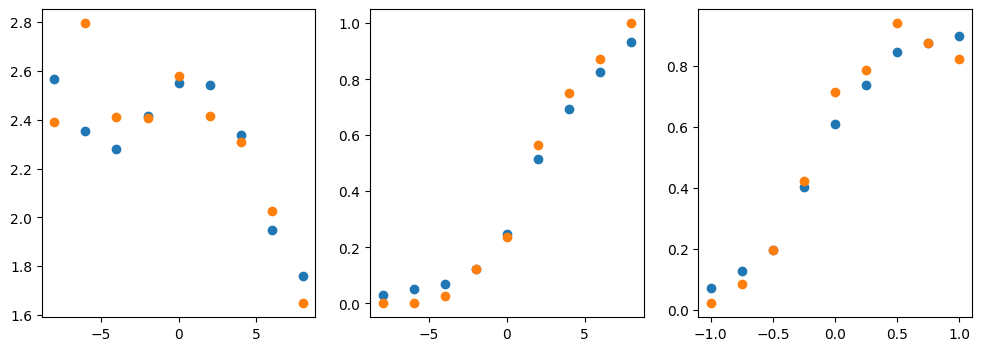

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Mean Other Value')['Right Value - Mean Other Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Mean Other Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['right'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Mean Other Value')['Right Value - Mean Other Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Mean Other Value')['choice_2'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['right'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - O)')['Dwell Time Advantage (R - O)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - O)')['choice_2'].mean());

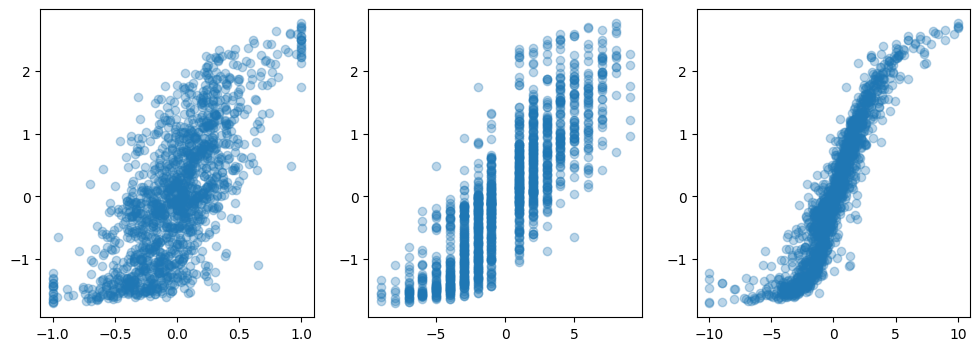

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 1], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 1]*X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

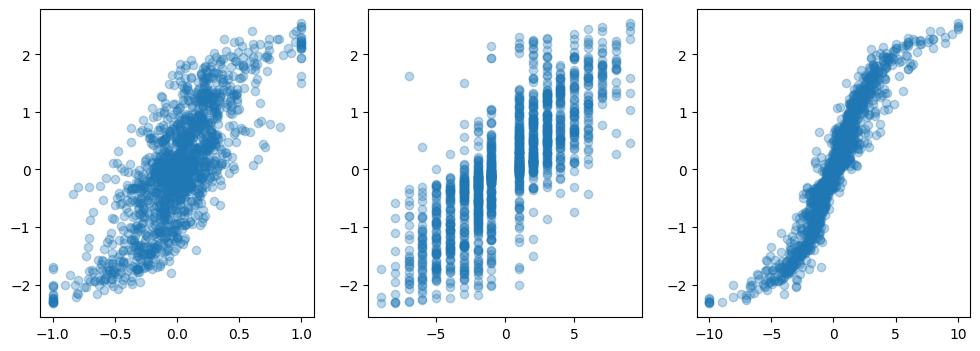

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 0], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 0]*X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);


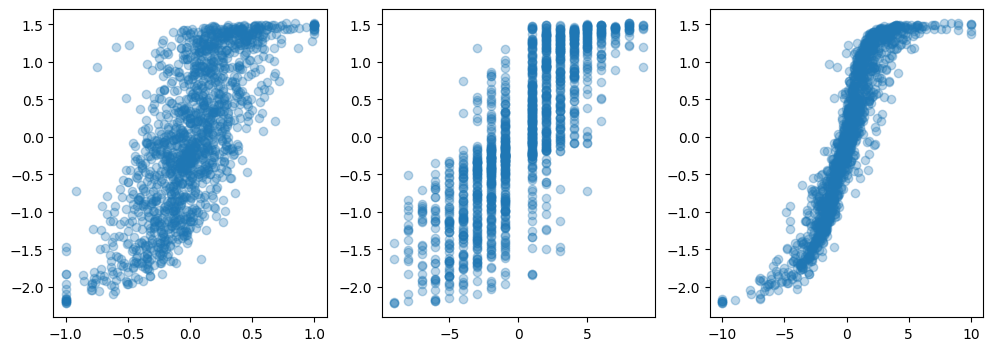

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 4] - X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 1] - X_test[:, 0], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 4] - X_test[:, 0]*X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);